# Anaesthesia DBS - Anomaly Detection pipeline

## Load the libraries/packages needed

In [1]:
import pyod
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline

# Show Multiple outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### User-defined helper functions

In [2]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score

def metrics_dataframe(model, y_test, prediction=None, X_test=None, metrics=['accuracy_score', 'matthews_corrcoef','f1_score', 'precision_score', 'recall_score', 'roc_auc_score']):
    
    if X_test is not None:
        prediction = model.predict(X_test)
    
    MCC = matthews_corrcoef(y_test, prediction)
    ACC = accuracy_score(y_test, prediction)
    F1 = f1_score(y_test, prediction, average='weighted')
    SENS = recall_score(y_test, prediction)
    Prec = precision_score(y_test, prediction)
    AUC_ROC = roc_auc_score(y_test, prediction)
    df2 = pd.DataFrame([np.array([ACC, MCC, F1, Prec, SENS, AUC_ROC])], columns=metrics)
    df2 = df2.assign(model =[str(model)])
    
    df2.head()
    return(df2)

## Load Data

### Time Ranges Table for reading MAT file data

| Description      | Start Row | End Row     |
| :---        |    :----:   |          ---: |
| Epoch 1: Awake State as Propofol was given   | 0  | 900000   |
| Epoch 2: DBS & RoC   | 1140000        | 1440000      |
| Epoch 3: Recovery State   | 1800000        | 2090000      |



Epoch 1 details: Initial 15 minutes (900000 ms) of propofol administration (induction infusion)
After, 30000ms pulses of DBS in thalamus during half-rate propofol infusion - for maintenance of LOC.
15 minute recovery at the end of the study


In [3]:
2090000 - 1440000

650000

In [4]:
FEF_df = pd.read_csv('Data/FEF_data.csv', header = None)

In [20]:
epoch_1=FEF_df.iloc[0:900000, :]
epoch_2=FEF_df.iloc[1800000:2000000, :]
epoch_2.describe()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-0.155080,-0.151245,1.199985,0.992790,0.175685,0.983750,-0.162915,0.261170,0.421385,0.033805,...,0.821340,0.223980,0.436250,0.011300,1.118390,0.905315,0.816925,0.051260,0.561610,0.163880
std,469.812333,474.982646,531.597327,497.698988,416.849924,481.063172,430.275056,412.539349,409.782049,442.938682,...,451.416847,448.273046,394.024345,497.388713,501.522818,459.497084,423.988320,459.510612,377.669088,412.803968
min,-1960.000000,-1990.000000,-1936.000000,-1827.000000,-2099.000000,-1785.000000,-1741.000000,-1898.000000,-1959.000000,-2200.000000,...,-2028.000000,-2175.000000,-1941.000000,-2100.000000,-1872.000000,-1700.000000,-1657.000000,-2358.000000,-1685.000000,-1824.000000
25%,-289.000000,-292.000000,-332.000000,-311.000000,-256.000000,-301.000000,-270.000000,-266.000000,-259.000000,-268.000000,...,-281.000000,-274.000000,-242.000000,-299.000000,-314.000000,-284.000000,-267.000000,-278.000000,-237.000000,-257.000000
50%,42.000000,42.000000,62.000000,60.000000,45.000000,53.000000,26.000000,36.000000,43.000000,48.000000,...,65.000000,52.000000,45.000000,51.000000,62.000000,59.000000,54.000000,55.000000,37.000000,35.000000
75%,302.000000,307.000000,363.000000,344.000000,273.000000,329.000000,260.000000,277.000000,289.000000,284.000000,...,316.250000,299.000000,271.000000,318.000000,340.000000,318.000000,295.000000,297.000000,257.000000,270.000000
max,1663.000000,1671.000000,1653.000000,1565.000000,1490.000000,1558.000000,1692.000000,1798.000000,1473.000000,1616.000000,...,1502.000000,1466.000000,1434.000000,2139.000000,1616.000000,1487.000000,1328.000000,1660.000000,1381.000000,1530.000000


In [21]:
## Select our samples from each epoch
random.seed(321)

x_1 = epoch_1.sample(n=10000)
x_2 = epoch_2.sample(n=10000)

In [22]:
#train scaler only on the training sample

scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_1)


# if PCA is needed, set the hyperparameters of the compression
pca=PCA(.90)  # 90% of variance captured


In [23]:
# apply scaler to both samples

X1 = scaler.transform(x_1)
X2 = scaler.transform(x_2)


## Initialize the Detector algorithms

In [3]:
#from pyod.models.abod import ABOD
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

#### Hyperparameters of the detectors

In [4]:
random_state = 321

num_training_samples = 100000
num_test_samples = 5000
num_contamination_samples = 5000 # These are added to the test sample

total_test_size = num_test_samples + num_contamination_samples

# number of estimators for decision trees
n_estimators = 100

# assume contamination rate in training data
contaimination = 0.05



In [5]:
classifiers = {
        #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=contaimination),
        'One-Class SVM': OCSVM(kernel='rbf', nu=0.1, gamma='auto'),
        'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=contaimination, check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35), contamination=contaimination, check_estimator=False, random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=contaimination),
        'Isolation Forest': IForest(contamination=contaimination, random_state=random_state)
}

In [36]:
'''
# If you need a single ROI/data set with multiple classifiers, use this code block. Does the same thing with 1 fewer loop

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X1)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2)
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    #plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    #dfx = df
    #dfx['outlier'] = y_pred.tolist()
    is_outlier = y_pred.tolist()
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    #IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    #IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    #OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    #OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * contaimination)
        
    # decision function calculates the raw anomaly score for every point
    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    #Z = Z.reshape(xx.shape)
    
    
    '''


"\n# If you need a single ROI/data set with multiple classifiers, use this code block. Does the same thing with 1 fewer loop\n\nfor i, (clf_name, clf) in enumerate(classifiers.items()):\n    clf.fit(X1)\n    # predict raw anomaly score\n    scores_pred = clf.decision_function(X2)\n        \n    # prediction of a datapoint category outlier or inlier\n    y_pred = clf.predict(X2)\n    n_inliers = len(y_pred) - np.count_nonzero(y_pred)\n    n_outliers = np.count_nonzero(y_pred == 1)\n    #plt.figure(figsize=(10, 10))\n    \n    # copy of dataframe\n    #dfx = df\n    #dfx['outlier'] = y_pred.tolist()\n    is_outlier = y_pred.tolist()\n    # IX1 - inlier feature 1,  IX2 - inlier feature 2\n    #IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)\n    #IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)\n    \n    # OX1 - outlier feature 1, OX2 - outlier feature 2\n    #OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)\n    #OX2 =  dfx

## Multiple ROI pipeline

In [6]:
ROI_data = {
    'FEF': 'Data/FEF_data.csv', 
    'PPC': 'Data/PPC_data.csv', 
    'STG': 'Data/STG_data.csv', 
    'vlPFC':'Data/vlPFC_data.csv', 
    'rAntThal':'Data/rAntThal_allBipolars_data.csv',
    'rPostThal': 'Data/rPostThal_allBipolars_data.csv',
}

ROI_data

{'FEF': 'Data/FEF_data.csv',
 'PPC': 'Data/PPC_data.csv',
 'STG': 'Data/STG_data.csv',
 'vlPFC': 'Data/vlPFC_data.csv',
 'rAntThal': 'Data/rAntThal_allBipolars_data.csv',
 'rPostThal': 'Data/rPostThal_allBipolars_data.csv'}

In [38]:
results = pd.DataFrame()

for i, (ROI_name, data_file_loc) in enumerate(ROI_data.items()):
    
    all_data_df = pd.read_csv(data_file_loc, header = None)
    
    x_1=all_data_df.iloc[0:900000, :].sample(n=num_training_samples)
    x_2=pd.concat([all_data_df.iloc[1800000:2000000, :].sample(n=num_test_samples), all_data_df.iloc[1140000:1440000, :].sample(n=num_contamination_samples)])
    
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_1)
    
    # apply scaler
    X1 = scaler.transform(x_1)
    X2 = scaler.transform(x_2)
    
    print('ROI : ', ROI_name, 'Fitting Anomaly Detectors')
    
    # Main loop
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        
        # PCA fit if One-class SVM is used:
        if clf_name == 'One-Class SVM':
            
            tempFit_pca=pca.fit(X1)
            X1 = tempFit_pca.transform(X1)
            X2 = tempFit_pca.transform(X2)
        
        
        clf.fit(X1)
        # predict anomaly score (probability)
        scores_pred = clf.decision_function(X2)

        # prediction of a datapoint category outlier or inlier
        
        y_pred = clf.predict(X2)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        
        # Record Metrics dataframe
        y_test = np.concatenate((np.zeros(num_test_samples), np.ones(num_contamination_samples)), axis=0)
        temp_res = metrics_dataframe(model=clf, y_test=y_test, prediction=y_pred)
        temp_res['Model_Name'] = clf_name
        temp_res['RoI'] = ROI_name
        
        results = pd.concat([results, temp_res])
        
        #plt.figure(figsize=(10, 10))
        
        # copy of dataframe
        #dfx = df
        #dfx['outlier'] = y_pred.tolist()
        is_outlier = y_pred.tolist()
        
        #IX1 - inlier feature 1,  IX2 - inlier feature 2
        #IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
        #IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)

        # OX1 - outlier feature 1, OX2 - outlier feature 2
        #OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
        #OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)

        print(clf_name, '  OUTLIERS: ', n_outliers, '  INLIERS: ', n_inliers)

        # threshold value to consider a datapoint inlier or outlier
        #threshold = stats.scoreatpercentile(scores_pred,100 * contaimination)
        


ROI :  FEF Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  6235   INLIERS:  3765


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  5394   INLIERS:  4606


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  4496   INLIERS:  5504


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  4752   INLIERS:  5248


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  5171   INLIERS:  4829
ROI :  PPC Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  4031   INLIERS:  5969


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  3899   INLIERS:  6101


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  3348   INLIERS:  6652


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  3580   INLIERS:  6420


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  3967   INLIERS:  6033
ROI :  STG Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  3212   INLIERS:  6788


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  2703   INLIERS:  7297


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  1962   INLIERS:  8038


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  2330   INLIERS:  7670


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  2442   INLIERS:  7558
ROI :  vlPFC Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  6452   INLIERS:  3548


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  5991   INLIERS:  4009


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  5019   INLIERS:  4981


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  5426   INLIERS:  4574


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  5645   INLIERS:  4355
ROI :  rAntThal Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  908   INLIERS:  9092


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  339   INLIERS:  9661


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  439   INLIERS:  9561


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  302   INLIERS:  9698


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  337   INLIERS:  9663
ROI :  rPostThal Fitting Anomaly Detectors


OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

One-Class SVM   OUTLIERS:  1841   INLIERS:  8159


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=321,
   use_weights=False)

Cluster-based Local Outlier Factor (CBLOF)   OUTLIERS:  1177   INLIERS:  8823


FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, novelty=True, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.05,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=321, verbose=0)

Feature Bagging   OUTLIERS:  1451   INLIERS:  8549


HBOS(alpha=0.1, contamination=0.05, n_bins=10, tol=0.5)

Histogram-base Outlier Detection (HBOS)   OUTLIERS:  1084   INLIERS:  8916


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=321, verbose=0)

Isolation Forest   OUTLIERS:  1163   INLIERS:  8837


In [39]:
 results.describe()

,accuracy_score,matthews_corrcoef,f1_score,precision_score,recall_score,roc_auc_score
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.449127,-0.092482,0.407089,0.488066,0.266113,0.449127
std,0.072253,0.164888,0.051748,0.142624,0.143530,0.072253
min,0.306200,-0.388809,0.305121,0.320356,0.043200,0.306200
25%,0.415175,-0.192480,0.378713,0.366744,0.163100,0.415175
50%,0.445750,-0.112012,0.407302,0.430754,0.278700,0.445750
75%,0.514875,0.075345,0.442293,0.628340,0.346800,0.514875
max,0.548900,0.152534,0.498449,0.729970,0.495600,0.548900


In [40]:
results

,accuracy_score,matthews_corrcoef,f1_score,precision_score,recall_score,roc_auc_score,model,Model_Name,RoI
0,0.3415,-0.327136,0.331301,0.372895,0.4650,0.3415,"OCSVM(cache_size=200, coef0=0.0, contamination...",One-Class SVM,FEF
0,0.3062,-0.388809,0.305121,0.320356,0.3456,0.3062,"CBLOF(alpha=0.9, beta=5, check_estimator=False...",Cluster-based Local Outlier Factor (CBLOF),FEF
0,0.3956,-0.209869,0.394061,0.383897,0.3452,0.3956,FeatureBagging(base_estimator=LOF(algorithm='a...,Feature Bagging,FEF
0,0.3700,-0.260320,0.369612,0.363215,0.3452,0.3700,"HBOS(alpha=0.1, contamination=0.05, n_bins=10,...",Histogram-base Outlier Detection (HBOS),FEF
0,0.3587,-0.282765,0.358512,0.363373,0.3758,0.3587,"IForest(behaviour='old', bootstrap=False, cont...",Isolation Forest,FEF
0,0.4441,-0.113961,0.438831,0.430662,0.3472,0.4441,"OCSVM(cache_size=200, coef0=0.0, contamination...",One-Class SVM,PPC
0,0.4501,-0.102311,0.443352,0.436009,0.3400,0.4501,"CBLOF(alpha=0.9, beta=5, check_estimator=False...",Cluster-based Local Outlier Factor (CBLOF),PPC
0,0.4728,-0.057637,0.458008,0.459379,0.3076,0.4728,FeatureBagging(base_estimator=LOF(algorithm='a...,Feature Bagging,PPC
0,0.4464,-0.111804,0.435007,0.425140,0.3044,0.4464,"HBOS(alpha=0.1, contamination=0.05, n_bins=10,...",Histogram-base Outlier Detection (HBOS),PPC
0,0.4451,-0.112221,0.439115,0.430804,0.3418,0.4451,"IForest(behaviour='old', bootstrap=False, cont...",Isolation Forest,PPC


<Figure size 1440x1440 with 0 Axes>

AttributeError: 'FacetGrid' object has no attribute 'axhline'

<Figure size 1440x1440 with 0 Axes>

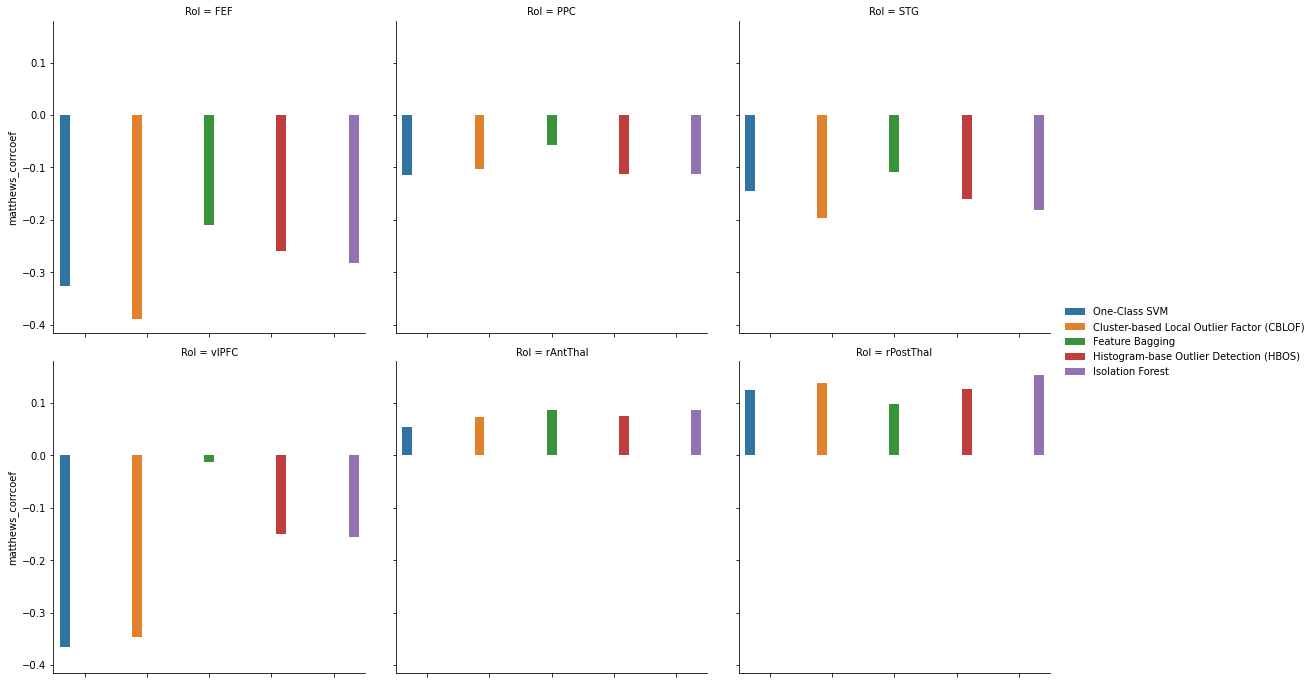

In [67]:
# Plot results with seaborn
plt.figure(figsize=(20, 20))
g = sns.catplot(data=results, x='Model_Name', y='matthews_corrcoef', col='RoI', hue='Model_Name', legend=False, col_wrap=3, kind="bar").add_legend()
g2 = g.set(xlabel=None).set(xticklabels=[]).axhline(y=0)
plt.show()

In [68]:
results.to_csv("/home/sean/Work/Anesthesia_DBS/anomalydetect_10k.csv")